# Make the photometry of the companion star

- author : Sylvie Dagoret
- date June 19 2019

Use Photutils

In [222]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time
from astropy.io import fits

In [223]:
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import DAOStarFinder
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [224]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(15,15)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points

In [225]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    For example for the PSF
    
    x=pixel number
    y=Intensity in pixel
    
    values-x
    weights=y=f(x)
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  # Fast and numerically precise
    return average, np.sqrt(variance)


In [226]:
def Show2Histo(data1,data2,title1,title2,cutmax=10):
    """
    """
    vmin1=data1.min()
    vmax1=data1.max()/cutmax
    vmin2=data2.min()
    vmax2=data2.max()/cutmax
  
    
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.hist(data1.flatten(),bins=100,range=(vmin1,vmax1))
    plt.grid(color="k")
    plt.title(title1)
    
    
    plt.subplot(222)
    plt.hist(data2.flatten(),bins=100,range=(vmin2,vmax2))
    
    plt.grid(color="k")
    plt.title(title2)

In [227]:
def Show2Images(data1,data2,title1,title2,cutmax=10):
    """
    """
    
    vmin1=data1.min()
    vmax1=data1.max()/cutmax
    vmin2=data2.min()
    vmax2=data2.max()/cutmax
    
    norm = ImageNormalize(stretch=SqrtStretch())
    
    plt.figure(figsize=(20,26))
    plt.subplot(221)
    img1=plt.imshow(data1,origin="lower",cmap="jet",vmin=vmin1,vmax=vmax1,norm=norm)
    plt.grid(color="w")
    plt.title(title1)
    plt.xlabel(" X - pixel ")
    plt.ylabel(" Y - pixel ")
    plt.colorbar(img1,orientation="horizontal")
    plt.subplot(222)
    img2=plt.imshow(data2,origin="lower",cmap="jet",vmin=vmin2,vmax=vmax2,norm=norm)
    plt.grid(color="w")
    plt.title(title2)
    plt.xlabel(" X - pixel ")
    plt.ylabel(" Y - pixel ")
    plt.colorbar(img2,orientation="horizontal")

In [228]:
def FindSources(data):
    """
    """
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)    
    sources = daofind(data - median) 
    #sources = daofind(data) 
    return sources

In [229]:
def GetExtractionParam(sources,width=20):
    """
    """
    
    y0=sources["ycentroid"][0]
    x0=sources["xcentroid"][0]

    xmin=int(x0-width)
    xmax=int(x0+width)
    ymin=int(y0-width)
    ymax=int(y0+width)
    
    return x0,y0,xmin,xmax,ymin,ymax

In [230]:
def GetBackground(data):
    """
    """
    #mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
    mask = make_source_mask(data, snr=3, npixels=10)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    print((mean, median, std))  
    
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (20, 20), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    
    return bkg  

In [231]:
# where are the spectra
#----------------------
thedate = "20190215"
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [232]:
file1="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit" 
file2="T1M_20190216_040015_897_HD116405_Filtre_None_bin1x1.346_red.fit"

In [233]:
title1=file1.split("_Filtre_None_")[0]
title2=file2.split("_Filtre_None_")[0]

In [234]:
fullfilename1=os.path.join(rawinput_directory,file1)
fullfilename2=os.path.join(rawinput_directory,file2)

In [235]:
hdu1 = fits.open(fullfilename1)
hdu2 = fits.open(fullfilename2)

In [236]:
img1=hdu1[0].data
img2=hdu2[0].data

In [237]:
data1=img1

In [238]:
data2=img2

# Show rawfull  image

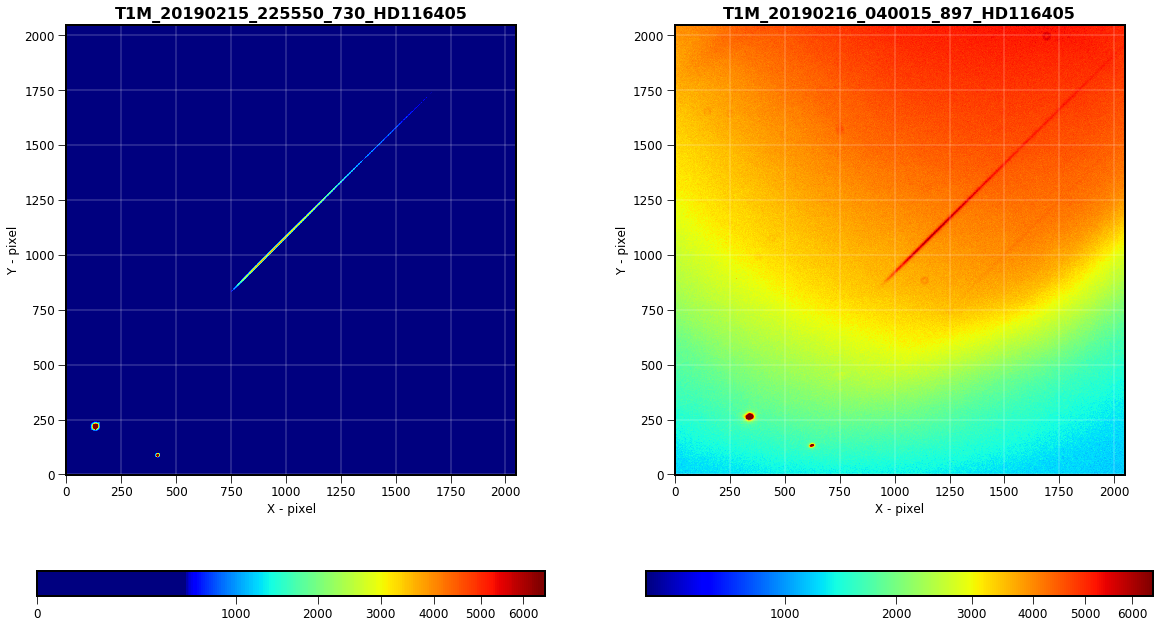

In [239]:
Show2Images(data1,data2,title1,title2,cutmax=10)

In [240]:
cutimg1=data1[0:750,0:750]
cutimg2=data2[0:750,0:750]

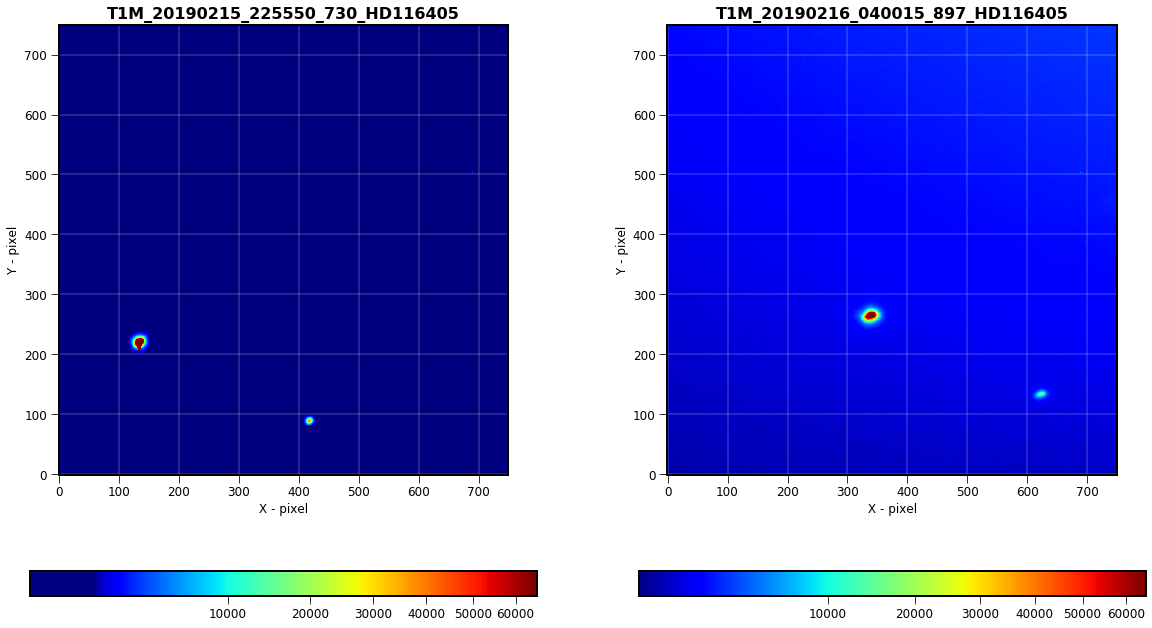

In [241]:
Show2Images(cutimg1,cutimg2,title1,title2,cutmax=1)

# Find sources

In [242]:
sources1=FindSources(cutimg1)
sources2=FindSources(cutimg2)

In [243]:
positions1 = (sources1['xcentroid'], sources1['ycentroid'])
positions2 = (sources2['xcentroid'], sources2['ycentroid'])

In [244]:
for col in sources1.colnames:    
    sources1[col].info.format = '%.8g'  # for consistent table output
print("sources1") 
print(sources1)  

sources1
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 416.82349 89.841687 0.55505862 ...   0 42997.851 792.12038   -7.246978
  2 131.36828 220.22083 0.39960252 ...   0 64594.423 725.86477  -7.1521393
  3 135.39845 222.28779 0.32487395 ...   0 64925.375  821.6427  -7.2867075
  4 400.91073 247.45616 0.74895549 ...   0 122.06686 1.8371896 -0.66038492


In [245]:
for col in sources2.colnames:    
    sources2[col].info.format = '%.8g'  # for consistent table output
print("sources2") 
print(sources2)  

sources2
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 623.38927 134.69142 0.49776238 ...   0 13651.764 6.2190272 -1.9843061
  2 335.89625 263.81104 0.33908469 ...   0 61930.916 23.421514 -3.4240374
  3 341.76198 266.19114 0.31754449 ...   0  62120.97 22.858441 -3.3976165


In [246]:
sources1

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,416.82349,89.841687,0.55505862,0.24712491,-0.027605732,169,0,42997.851,792.12038,-7.246978
2,131.36828,220.22083,0.39960252,0.058765839,0.64615658,169,0,64594.423,725.86477,-7.1521393
3,135.39845,222.28779,0.32487395,-0.10523389,0.29876359,169,0,64925.375,821.6427,-7.2867075
4,400.91073,247.45616,0.74895549,0.20446992,0.094260166,169,0,122.06686,1.8371896,-0.66038492


In [247]:
sources2

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,623.38927,134.69142,0.49776238,0.29069922,-0.71362668,169,0,13651.764,6.2190272,-1.9843061
2,335.89625,263.81104,0.33908469,0.30975638,-0.34796614,169,0,61930.916,23.421514,-3.4240374
3,341.76198,266.19114,0.31754449,0.058464045,-0.27117751,169,0,62120.97,22.858441,-3.3976165


In [248]:
width=30
x01,y01,xmin1,xmax1,ymin1,ymax1=GetExtractionParam(sources1,width=width)
x02,y02,xmin2,xmax2,ymin2,ymax2=GetExtractionParam(sources2,width=width)

In [249]:
vignette1=data1[ymin1:ymax1,xmin1:xmax1]
vignette2=data2[ymin2:ymax2,xmin2:xmax2]

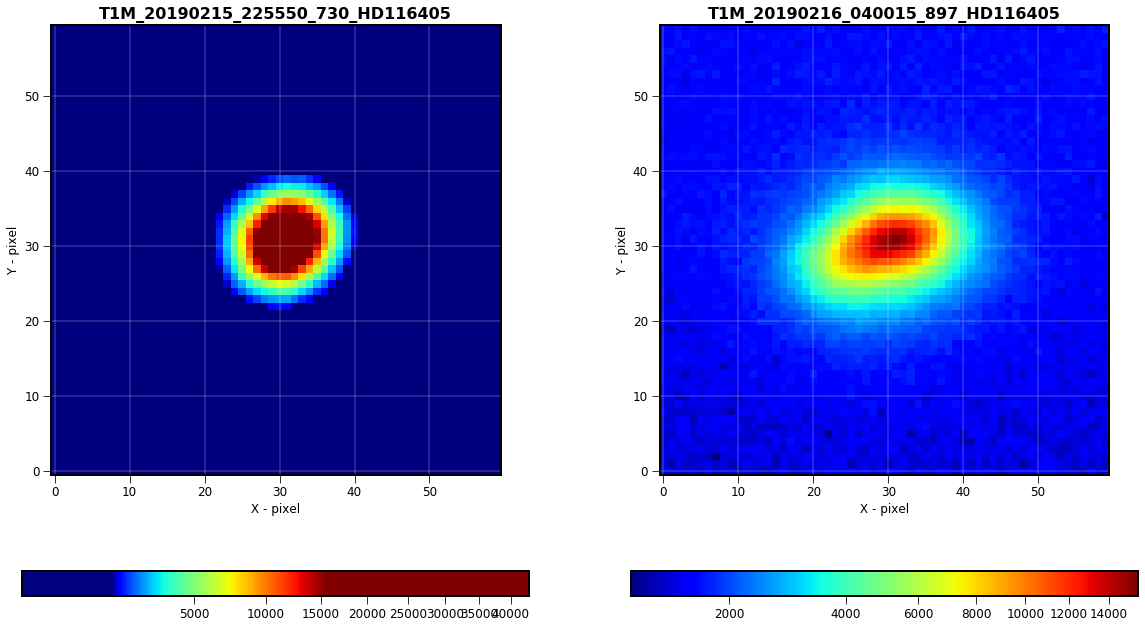

In [250]:
Show2Images(vignette1,vignette2,title1,title2,cutmax=1)

# Background

In [251]:
bkg1=GetBackground(vignette1)
bkg2=GetBackground(vignette2)

(116.19138774181718, 114.51209973267103, 18.94026555963478)
(1657.2766589698554, 1658.3428885717422, 69.25500800458434)


In [252]:
#mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
mask1 = make_source_mask(vignette1, snr=3, npixels=5)
mask2 = make_source_mask(vignette2, snr=3, npixels=5)
mean1, median1, std1 = sigma_clipped_stats(vignette1, sigma=3.0, mask=mask1)
mean2, median2, std2 = sigma_clipped_stats(vignette2, sigma=3.0, mask=mask2)

In [253]:
signal1=vignette1-median1
signal2=vignette2-median2

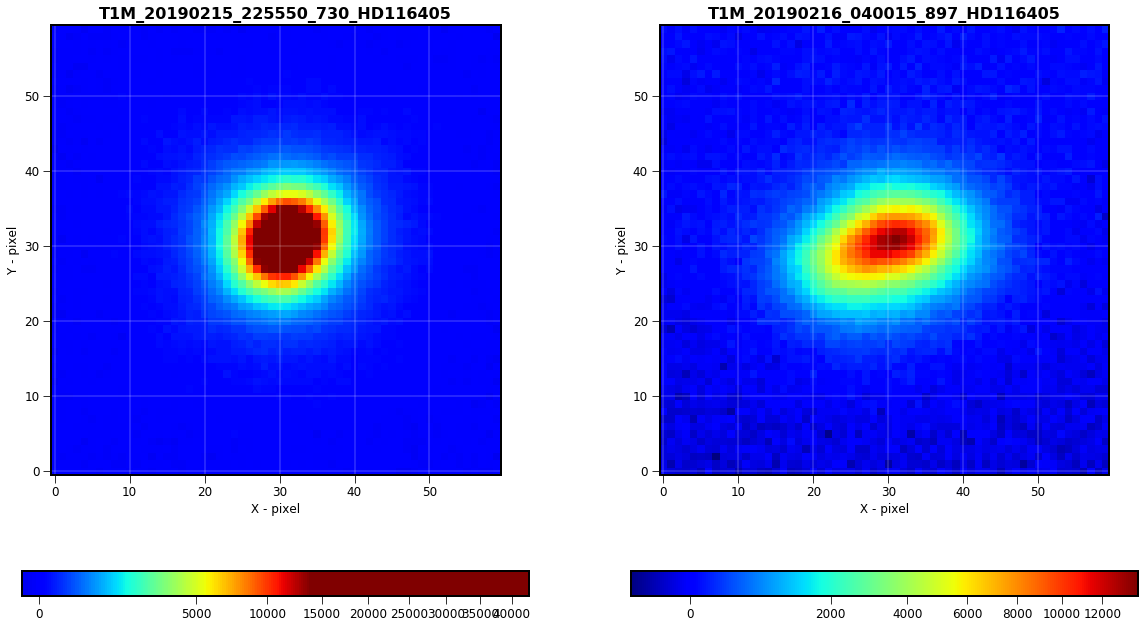

In [254]:
Show2Images(signal1,signal2,title1,title2,cutmax=1)

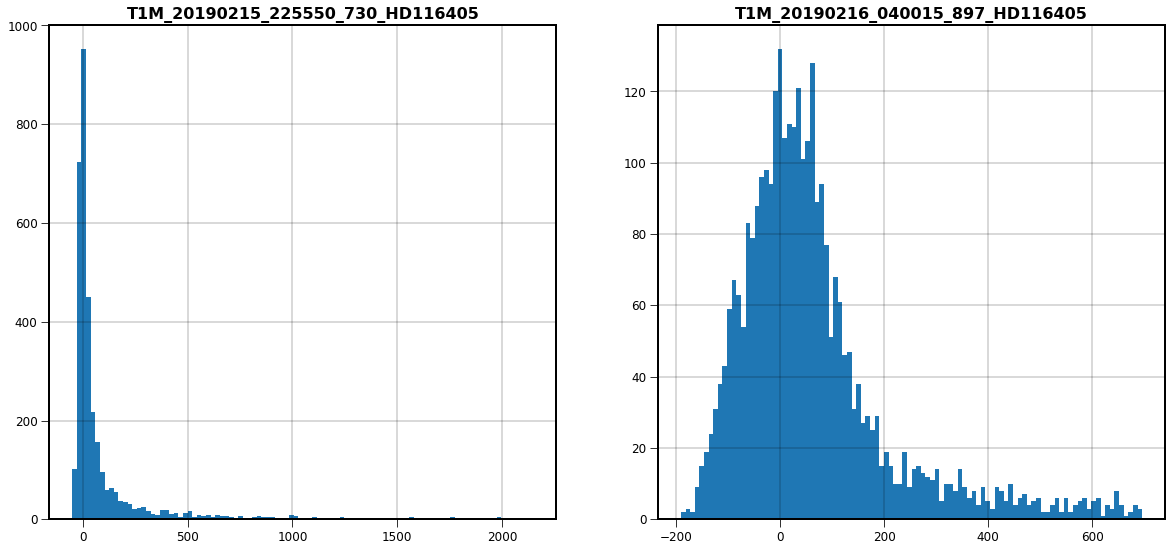

In [255]:
Show2Histo(signal1,signal2,title1,title2,cutmax=20)

# Photometry

In [256]:
from photutils import aperture_photometry
from photutils import CircularAperture

In [257]:
apertures1 = CircularAperture((width,width), r=25.)
apertures2 = CircularAperture((width,width), r=25.)

In [258]:
phot_table1 = aperture_photometry(signal1, apertures1)
phot_table2 = aperture_photometry(signal2, apertures2)

In [259]:
for col in phot_table1.colnames:    
    phot_table1[col].info.format = '%.8g'  # for consistent table output

In [260]:
for col in phot_table2.colnames:    
    phot_table2[col].info.format = '%.8g'  # for consistent table output

In [261]:
phot_table1

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,30,30,2740286.8


In [262]:
phot_table2

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,30,30,1895507
